<h2> Infrastructure </h2>

<h3> Import Libraries </h3>

In [1]:
# Initialization code for 1.8 V SiGe PMOS LDO Testing. 
# Adapted by Shawn for PMOS_LDO from Langdon's code for NPN_LVR (which was based off Sean's code)
# This block identifies and initializes the connected SMUs (Source Measure Units).

import pyvisa                    # Instrument communication
import time                      # Handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis
import os                        # Interact with the operating system, such as handling file paths
import csv                       # Read from and write to CSV files
from datetime import date        # Read current date
from collections import defaultdict

<h3> Plotting Helpers</h3>

In [2]:
def start_plot(title, xlabel, ylabel):
    # Create a color map for the plots
    cm=plt.get_cmap('gist_rainbow')

    # Apply default parameters that are shared by all plots. Any property can be changed afterwards if needed.
    fig, plot = plt.subplots(layout='constrained')
    plot.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    plot.set_xlabel(xlabel, fontdict={'fontsize': 12})
    plot.set_ylabel(ylabel, fontdict={'fontsize': 12})
    plot.tick_params(axis='both', which='major', labelsize=10)
    plot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
    plot.grid()
    return fig, plot

# Below - plot, fig, directory, and name are POSITIONAL arguments - when calling function, must insert those first and in
# the same order. 'legend' and 'close' are KEYWORD arguments - when calling function, their order does not matter (as long
# as they come after the positional), but you must write out the name and '=' for each. Keyword arguments are optional. 
# If not provided, the default values in the definition below (True) will be assumed.
def finish_plot(plot, fig, directory, name, legend=True, close=True): 
    if (legend):
        for line in plot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines(): # Creates legend
            line.set_linewidth(2.5) # Changes widths of the legend's example lines, NOT the actual lines on the plot
    if (close):
        plt.close(fig) #Saves memory, faster
    fig.savefig(os.path.join(directory, name))

# Determine the appropriate scaling for generated plots in Engineering Notation
def scale(list):
    array = np.asarray(list, dtype='float') # Python doesn't support multiplying a list by a float. Numpy does.
    if np.max(np.abs(array)) < 1e-9:
        k = 1e12
    elif np.max(np.abs(array)) < 1e-6:
        k = 1e9
    elif np.max(np.abs(array)) < 1e-3:
        k = 1e6
    elif np.max(np.abs(array)) < 1:
        k = 1e3
    else:
        k = 1
    
    return k*array # Return the scaled array

# Determine the appropriate prefix for arrays that use scale(). USE ORIGINAL LIST, NOT THE SCALED
def prefix(list):
    array = np.asarray(list, dtype='float')
    if np.max(np.abs(array)) < 1e-9:
        k = 1e12
        prefix = 'p'
    elif np.max(np.abs(array)) < 1e-6:
        k = 1e9
        prefix = 'n'
    elif np.max(np.abs(array)) < 1e-3:
        k = 1e6
        prefix = 'µ'
    elif np.max(np.abs(array)) < 1:
        k = 1e3
        prefix = 'm'
    else:
        k = 1
        prefix = ''

    return prefix

<h3> Numerical Constants </h3>

In [46]:
# Circuit Values
Rhi=264.3
Rlo=68000

# Desired Values
ILMAX=-.01        # Never used. Also different sign from all other currents? -Shawn
IL_default=.003   # Used for tests outside of the IL sweep. Load current.
VREF_default = .8 # Used when tests are not actively being run

#Sweeps
VIN_MAX=1.8
VIN_STEP=-.025
VIN_MIN=1
# Full VIN list isn't created until the tests, since the minimum value will change.
print("VIN: " + str(np.arange(VIN_MAX, VIN_MIN+VIN_STEP, VIN_STEP)))

VREF_MAX=1.7
VREF_STEP=-.1
VREF_MIN=.6
VREFlist_unrounded = np.arange(VREF_MAX, VREF_MIN+VREF_STEP, VREF_STEP) # Adding the step to the second argument will include its value in the sweep.
#print(VREFlist_unrounded)
VREFlist = [round(VREF, 5) for VREF in VREFlist_unrounded] #If you don't round it'll display the floats with the precision they're stored. i.e. 2 -> 1.99999999999999995
VREFlist.append(.3)
print("VREF: " + str(VREFlist))
# test = [VREF+1 for VREF in VREFlist]
# print(test)

TEMPlist = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]

ILlist = [100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3]
ILlistmA = scale(ILlist)
print(ILlistmA)

VIN=[]
ITOT=[]
VOUT=[]

VIN: [1.8   1.775 1.75  1.725 1.7   1.675 1.65  1.625 1.6   1.575 1.55  1.525
 1.5   1.475 1.45  1.425 1.4   1.375 1.35  1.325 1.3   1.275 1.25  1.225
 1.2   1.175 1.15  1.125 1.1   1.075 1.05  1.025 1.   ]
VREF: [np.float64(1.7), np.float64(1.6), np.float64(1.5), np.float64(1.4), np.float64(1.3), np.float64(1.2), np.float64(1.1), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(0.7), np.float64(0.6), 0.3]
[ 0.1  0.3  0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10. ]


<h3> Find available devices </h3>

In [4]:
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

('USB0::0x2A8D::0x0101::MY54505624::INSTR',
 'USB0::0x0957::0x5707::MY53802060::INSTR',
 'USB0::0x2A8D::0x0101::MY57508183::INSTR',
 'GPIB6::6::INSTR',
 'GPIB6::20::INSTR',
 'USB0::0x0957::0x0607::MY45002108::0::INSTR',
 'USB0::0x0957::0x1796::MY57231548::0::INSTR',
 'USB0::0x0957::0x1796::MY57231553::0::INSTR',
 'USB0::0x0957::0x17B6::MY56310504::0::INSTR',
 'USB0::0x0957::0x2C07::MY57890777::0::INSTR')

<h3> Connect Equipment </h3>

In [31]:
# If running for the first time, ensure the equipment names are correctly referenced

def establish_connection(address, query):
    instrument = rm.open_resource(address)   # Open a connection to the instrument with the address and assign it to SM_VIN
    instrument.read_termination = '\n'       # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
    instrument.write_termination = '\n'      # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
    instrument.baud_rate = 9600              # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
    print(instrument)                        # Print the resource object to display its properties
    print(instrument.query(query))         # Send the query to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).
    #instrument.write('STATUS?')
    #instrument.read_bytes(1)
    return instrument

SM_VIN = establish_connection('GPIB6::20::INSTR', '*IDN?') # Also measures current through VIN
WG_VREF_VISET = establish_connection('USB0::2391::22279::MY53802060::0::INSTR', '*IDN?')

GPIBInstrument at GPIB6::20::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2401,4636506,B02 Jan 20 2021 10:19:49/B01  /W/N
USBInstrument at USB0::2391::22279::MY53802060::0::INSTR
Agilent Technologies,33622A,MY53802060,A.01.11-2.25-03-64-02


In [ ]:
MM_VDROP = establish_connection('USB0::10893::257::MY57508183::0::INSTR', '*IDN?')
MM_VOUT = establish_connection('USB0::0x2A8D::0x0101::MY54505624::INSTR', '*IDN?')

In [6]:
CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')

GPIBInstrument at GPIB6::6::INSTR
NNNNNNNNNNNNNNNNNN0


<h3> Equipment Functions </h3>

In [ ]:
####### Temperature Chamber #######

def Chamber_INIT():
    CHAMBER.write("ON")
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
    CHAMBER.write("WAIT=30")            # Sets the time that the chamber will wait once the desired temperature is reached before measurements start
    CHAMBER.write("HON")                # Turns heat on
    CHAMBER.write("CON")                # Turns cool on
    CHAMBER.write("PIDA=3")             # 
    time.sleep(1) 

    print(CHAMBER.query("RATE?"))
    print(CHAMBER.query("WAIT?"))

####### SMU #######

# TODO: Leading Colons? - Shawn
def SMU_INIT(SM):
    SM.write(":CONF:CURR")                  # Configure the SMU to measure current
    SM.write("OUTP:STAT 0")                 # Turn off the VIN source meter
    SM.write("SOUR:VOLT:RANG 1.8")
    SM.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
    SM.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
    SM.timeout = 100000                     # Set the timeout for the SMU operations to 100,000 milliseconds (100 seconds).
    SM.write("CURR:NPLC 10")
    SM.write("SYST:BEEP:STAT OFF")           # Turn off the beeper on the SMU

def SMU_On(SM, val):
    SM.write(":SOUR:VOLT:MODE FIX")
    SM.write("SOUR:VOLT:LEV "+str(val))
    SM.write("OUTP ON")

def SMU_Off(SM):
    SM.write("SOUR:VOLT:LEV 0")
    SM.write("OUTP:STAT 0")

####### MM #######

def MM_INIT(MM):
    MM.write(":CONF:VOLT:DC")
    MM.write("VOLT:DC:RANG 10")
    MM.write("VOLT:NPLC 10")

####### WG #######

def WG_INIT(WG):
    WG.write("OUTP1:LOAD DEF")          # Sets the output load to infinite so no impedance matching is necessary
    WG.write("OUTP2:LOAD DEF")
    WG.write("SOUR1:APPL:DC")          # Sets the Waveform generator to output a DC voltage
    WG.write("SOUR2:APPL:DC")          # Sets the Waveform generator to output a DC voltage

def WG_On(WG, channel, val):
    if (channel != 1 and channel != 2):
        print("Invalid channel")
        return -1
    WG.write(f"SOUR{channel}:APPL:DC DEF, DEF, {val}")
    WG.write(f"OUTP{channel}:STAT 1")

def WG_Off(WG, channel):
    if (channel != 1 and channel != 2):
        print("Invalid channel")
        return -1
    WG.write(f"SOUR{channel}:APPL:DC DEF, DEF, 0")
    WG.write(f"OUTP{channel}:STAT 0")

####### Groupings #######
# Do not affect temperature chamber

def initialize_all():
    SMU_INIT(SM_VIN)
    MM_INIT(MM_VOUT)
    MM_INIT(MM_VDROP)
    WG_INIT(WG_VREF_VISET) 

def turn_on_all():
    #TODO: TURN ON VREF BEFORE VIN? -Lang
    WG_On(WG_VREF_VISET, 1, VREF_default)
    SMU_On(SM_VIN, 1.8)            # Turn on the VIN source meter output
    time.sleep(.5)
    VISET = -Rhi*(IL_default-(VREF_default)/Rlo) + (VREF_default)
    WG_On(WG_VREF_VISET, 2, VISET)  # Turn on the WG for VISET to set IL to default for the first VREF so that it can warm up while CHAMBER starts

def turn_off_all():
    WG_Off(WG_VREF_VISET, 2)    # Turn off VISET first!!!
    time.sleep(.5)
    SMU_Off(SM_VIN)             # Turn off the VIN source meter
    WG_Off(WG_VREF_VISET, 1)    # Turn off VREF

<h3> Test Equipment </h3>

In [13]:
initialize_all()

In [15]:
# Test Multimeters
MM_INIT(MM_VOUT)
print(MM_VOUT.query(":CONF?"))
print(MM_VOUT.query(":READ?"))

MM_INIT(MM_VDROP)
print(MM_VDROP.query(":CONF?"))
print(MM_VDROP.query(":READ?"))

"VOLT +1.00000000E+01,+1.00000000E-06"
-2.83269973E-06
"VOLT +1.00000000E+01,+1.00000000E-06"
-2.15409821E-06


In [16]:
# Test SourceMeter
SMU_INIT(SM_VIN)
print(SM_VIN.query(":CONF?"))

"CURR:DC"


In [18]:
# Test Waveform Generator?
WG_INIT(WG_VREF_VISET)
#print(WG_VREF_VISET.query(":CONF?")) # Untested - Shawn

In [19]:
turn_on_all()

In [20]:
turn_off_all()

<h2> Experimental Procedure </h2>

<h3> Sweep Definitions </h3>

In [59]:
# Varies VREF. For each VREF, varies VIN, then IL. 
# Plots Line Regulation and Load Regulation.
# Records the VOUT corresponding to the largest VIN for the Voltage Regulation Plot
# Records calculated Dropout Voltage (from smallest VIN and corresponding VOUT) for the Dropout Voltage Plot
def VREF_Sweep(local, TEMP):
    VISETlist=[]
    VDOlist=[]
    VOUTreglist=[]
    for VREF in VREFlist:                                   
        ####### Sets VISET then VREF #######
        VISET = -Rhi*(IL_default-(VREF)/Rlo) + (VREF)
        print(f"Rlo = {Rlo}")
        print(f"Rhi = {Rhi}")
        print(f"IL_default = {IL_default}")
        print(f"VREF = {VREF}")
        print(f"VISET = {VISET}")
        VISETlist.append(VISET)
        WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF, " + str(VISET))   # Sets VISET to needed value to achieve default IL
        time.sleep(.1)                                                 # Set VISET before VREF because VREF is being swept up. Want to limit current
        WG_VREF_VISET.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF))    # Sets VREF
        time.sleep(1)

        ####### Sweeps #######
        VDO, VOUTreg = VIN_Sweep(VREF, local)    # Calls the VIN_Sweep function that sweeps VIN
        time.sleep(.1)
        IL_Sweep(VREF, local, TEMP)      # Calls the IL_Sweep function that sweeps IL
        
        VDOlist.append(VDO)
        VOUTreglist.append(VOUTreg)   
        
    # Restore default VREF and VISET
    WG_VREF_VISET.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF_default)) # VREF
    # Why no sleep time here? - Shawn
    VISET = -Rhi*(IL_default-(VREF_default)/Rlo) + (VREF_default)           # Restores IL (with VISET)
    WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF," + str(VISET))
    SM_VIN.query(":READ?").split(',')[1]
    MM_VOUT.query(":READ?")
    MM_VDROP.query(":READ?")
    # time.sleep(1)
    # Create an excel file with each VISET value used for each VREF
    df2 = pd.DataFrame({'VREF': VREFlist, 'VISET': VISETlist})
    csv_path = os.path.join(local, "VISET") 
    df2.to_csv(csv_path, index=False)
    # time.sleep(1)

    return(VDOlist, VOUTreglist)

#Called from VREF_Sweep for each VREF value, sweeps VIN.
def VIN_Sweep(VREF, local):
    ####### Creates Lists for Data #######              
    VINs=[]                                                  
    ITOTs=[] # Stores total current values (IQ + IL)
    VOUTs=[]                                                 
    VDROPs=[]
    
    for val in np.arange(VIN_MAX, VIN_MIN+VIN_STEP, VIN_STEP):  # Loop from VIN_MAX to VIN_MIN (or VREF if its higher) in steps of VIN_STEP                                                            
        val = round(val,5)                                     
        ####### Sets VIN voltage #######            
        SM_VIN.write("SOUR:VOLT:LEV " + str(val))           # Set VIN
        time.sleep(.5)                                      # Pause for .5 seconds to allow the system to stabilize
        
        ####### Measure ILOAD and others #######
        VOUT = float(MM_VOUT.query(":READ?"))
        if (VOUT < .3): # Move on to next VREF for safety if VOUT gets too low
            break
        VOUTs.append(VOUT)     
        ITOTs.append(SM_VIN.query(":READ?").split(',')[1])   # Query and append the measured total current through VIN
        VDROPs.append(float(MM_VDROP.query(":READ?")))
        VINs.append(val)                                     # Append VIN to list
    SM_VIN.write("SOUR:VOLT:LEV 1.8") 

    ####### Store Data #######
    df = pd.DataFrame({'VIN': VINs, 'ITOT': ITOTs, 'VOUT': VOUTs, 'VDROP': VDROPs}) # Create a pandas DataFrame from VIN, ITOT, and VOUT lists
    csv_path = os.path.join(local, "VIN_Sweep_VREF="+str(VREF)+".csv" )         # Generate the file path for saving the CSV
    df.to_csv(csv_path, index=False)                                            # Save the DataFrame to a CSV file without including the index
    
    VDO = VINs[-1] - VOUTs[-1]  # Calculate Dropout Voltage, to be used to generate plot.
    #VDO plot seems to be using the smallest VIN value (max of VIN_MIN, VREF-.1)
    
    return(VDO, VOUTs[0])


# Saves IL values and their Vout values for load regulation plot
def IL_Sweep(VREF, local, TEMP):
    ####### Creates Lists for Data #######               
    ITOTs=[]                                                 # Stores total current values (IQ + IL)
    VOUTs=[]                                                
    VDROPs=[]
    VISETs=[]
    for IL in ILlist:
        VISET = -Rhi*(IL-(VREF)/Rlo) + (VREF)
        WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF, "+str(VISET))
        VISETs.append(VISET)
        time.sleep(.5)
        VOUT = float(MM_VOUT.query(":READ?"))
        if (VOUT < .3):
            break
        VOUTs.append(VOUT)
        ITOTs.append(SM_VIN.query(":READ?").split(',')[1])   # Not used for any plots yet, saved anyways
        VDROPs.append(float(MM_VDROP.query(":READ?")))       # Not used for any plots yet, saved anyways
    VISET = -Rhi*(IL_default-(VREF)/Rlo) + (VREF)
    WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF, " +str(VISET))

    ####### Store Data #######
    df = pd.DataFrame({'IL': ILlist, 'ITOT': ITOTs, 'VOUT': VOUTs, 'VDROP': VDROPs, 'VISET': VISETs}) # Create a pandas DataFrame from lists
    csv_path = os.path.join(local, "IL_Sweep_VREF="+str(VREF)+".csv")                      
    df.to_csv(csv_path, index=False)


<h3> Procedure </h3>

In [ ]:
# UseChamber = True - turns on the temperature chamber and performs the temperature sweep
# UseChamber = False - performs a test run without the chamber.
# IMPORTANT: Make sure all CHAMBER commands are contained with an if(UseChamber):
def Run_Experiment(UseChamber):
    if (UseChamber):
        RUN_TYPE = "/Experiment_"
    else:
        RUN_TYPE = "/Practice_Run_"

    
    ################## Create Data Storage Directory ##################
    
    # Create file path
    DATE_DIR = "PMOS_LDO_Results/"+str(date.today())    # Create a directory with today's date.
    os.makedirs(DATE_DIR, exist_ok=True)                # If the directory already exists, it won't raise an error due to exist_ok=True
    i = 1
    RUN_DIR = str(DATE_DIR)+RUN_TYPE+str(i)
    while os.path.isdir(RUN_DIR) == True and len(os.listdir(RUN_DIR)) != 0 : # Checks if directory name is taken, updates run number until it is not. Makes sure directory isn't empty.
        i = i+1
        RUN_DIR = str(DATE_DIR)+RUN_TYPE+str(i)                
    os.makedirs(RUN_DIR, exist_ok=True)                 # Create another directory inside date directory for this specific trial
    
    
    ################## Initialize and format plots ##################
    
    # Dropout voltage plot
    DVfig, DVplot = start_plot('Dropout Voltage', 'Temperature (°C)', 'Vdo(Vin-Vout) (V)')
    DVplot.set_xticks(np.arange(-150, 150, 50))
    DVplot.set_xlim(-175, 125)
    #DVplot.set_yticks(np.arange(0, 1.3, 0.1))
    #DVplot.set_ylim(-175, 125)
    
    # Vout regulation plot
    VRfig, VRplot = start_plot('Vout Regulation at Vin=1.8V', 'Temperature (°C)', 'Vout (V)')
    VRplot.set_xticks(np.arange(-150, 150, 50))
    VRplot.set_xlim(-175, 125)

    # Create figures for the overall line regulation plots for each VREF
    LineRplot = defaultdict(list)
    LineRfig = defaultdict(list)
    for VREF in VREFlist:
        LineRfig[VREF], LineRplot[VREF] = start_plot('Line Regulation at VREF='+str(VREF)+'V', 'Vin (V)', 'Vout (V)')
        LineRplot[VREF].set_xticks(np.arange(max(VIN_MIN, VREF), 1.8, 0.1))
        LineRplot[VREF].set_xlim(VIN_MIN, 1.8)
    
    # Load regulation plot
    LoadRplot = defaultdict(list)
    LoadRfig = defaultdict(list)
    for VREF in VREFlist:
        LoadRfig[VREF], LoadRplot[VREF] = start_plot('Load Regulation at VREF='+str(VREF)+'V', 'IL (mA)', 'Vout (V)')
        LoadRplot[VREF].set_xticks(np.arange(-1, 11, 1))
        LoadRplot[VREF].set_xlim(0, ILlistmA[-1])
        #LoadRplot.set_xscale("log")

    # Cold Start Line regulation plot
    ColdLineRfig, ColdLineRplot = start_plot('Line Regulation Cold Start at T=-175 °C', 'Vin (V)', 'Vout (V)')
    ColdLineRplot.set_xticks(np.arange(max(VIN_MIN, VREF), 1.8, 0.1))
    ColdLineRplot.set_xlim(VIN_MIN, 1.8)

    # Cold Start Load regulation plot
    ColdLoadRfig, ColdLoadRplot = start_plot('Load Regulation Cold Start at T=-175 °C', 'IL (mA)', 'Vout (V)')
    ColdLoadRplot.set_xticks(np.arange(-1, 11, 1))
    ColdLoadRplot.set_xlim(0, ILlistmA[-1])
    #LoadRplot.set_xscale("log")
    
    
    ################## Initialize Equipment ##################
    
    if (UseChamber):
        Chamber_INIT()
    initialize_all()
    turn_on_all()
    
    
    ################## Temperature Sweep ##################
    
    VDOdict = defaultdict(list)
    VOUTregdict = defaultdict(list)
    
    if (UseChamber):
        TempsToTest = TEMPlist
    else:
        TempsToTest = [27]
        
    for TEMP in TempsToTest:
        TEMP_DIR=str(RUN_DIR)+"/TEMP_"+str(TEMP)                    # The temperature of the experiment gets set as the sub directory name
        os.makedirs(TEMP_DIR, exist_ok=True)                        # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True

        if (UseChamber):
            CHAMBER.write("WAIT=30")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
            CHAMBER.write("SET=" + str(TEMP))
            while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
                time.sleep(15)
                print(CHAMBER.query("STATUS?"))  
            print(CHAMBER.query("STATUS?"))
            time.sleep(300)                                         # Soak time
    
        VDOlist, VOUTreglist = VREF_Sweep(TEMP_DIR, TEMP)           # Performs every test. Sweeps VREF. For each VREF, sweeps VIN and IL
        #time.sleep(1)
        
        ####### Store data. Save this temperature's Line/load figs. #######
        for i, VREF in enumerate(VREFlist):
            VDOdict[VREF].append(VDOlist[i])
            VOUTregdict[VREF].append(VOUTreglist[i])
        
        
        for VREF in VREFlist:
            VIN_df = pd.read_csv(os.path.join(TEMP_DIR, "VIN_Sweep_VREF="+str(VREF)+".csv"))
            IL_df = pd.read_csv(os.path.join(TEMP_DIR, "IL_Sweep_VREF="+str(VREF)+".csv"))
            
            LineRplot[VREF].plot(VIN_df['VIN'], VIN_df['VOUT'], label="T="+str(TEMP)+" °C")
            LoadRplot[VREF].plot(ILlistmA, IL_df['VOUT'], label="T="+str(TEMP)+" °C")
            
            finish_plot(LineRplot[VREF], LineRfig[VREF], TEMP_DIR, "Line_Regulation_"+str(VREF)+"V.png", close=False)
            finish_plot(LoadRplot[VREF], LoadRfig[VREF], TEMP_DIR, "Load_Regulation_"+str(VREF)+"V.png", close=False)
    
    ################## Save Overall Figures ##################

    for VREF in VREFlist:
        finish_plot(LineRplot[VREF], LineRfig[VREF], RUN_DIR, "Line_Regulation_"+str(VREF)+"V.png")
        finish_plot(LoadRplot[VREF], LoadRfig[VREF], RUN_DIR, "Load_Regulation_"+str(VREF)+"V.png")
        DVplot.plot(TempsToTest, VDOdict[VREF], label="VREF="+str(VREF)+" (V)")
        VRplot.plot(TempsToTest, VOUTregdict[VREF], label="VREF="+str(VREF)+" (V)")

    finish_plot(DVplot, DVfig, RUN_DIR, "Dropout_Voltage.png")
    finish_plot(VRplot, VRfig, RUN_DIR, "Voltage_Regulation.png")

    

    ##################### Cold Start Test #####################
    
    # After temperature testing is complete, turn off the source meters
    turn_off_all()                                    # Turn off VREF
    if (UseChamber):
        CHAMBER.write("WAIT=30")                      # Reset wait time so that it doesn't time out
        time.sleep(900)                               # Wait 15 minutes for device to cool down
        CHAMBER.write("WAIT=30")                      # Same as above (TODO: There is probably a better way to do this)
    turn_on_all()

    TEMP_DIR = str(RUN_DIR)+"/TEMP_-175C_Cold_Start"
    os.makedirs(TEMP_DIR, exist_ok=True)

    VDOlist, VOUTreglist = VREF_Sweep(TEMP_DIR, TEMP) # Performs every test. Sweeps VREF. For each VREF, sweeps VIN and IL

    ####### Create and Store Line/Load Figs. #######
    for VREF in VREFlist:
        VIN_df = pd.read_csv(os.path.join(TEMP_DIR, "VIN_Sweep_VREF="+str(VREF)+".csv")) # Saved in VIN_Sweep()
        IL_df = pd.read_csv(os.path.join(TEMP_DIR, "IL_Sweep_VREF="+str(VREF)+".csv")) # Saved in IL_Sweep()
        ColdLineRplot.plot(VIN_df['VIN'], VIN_df['VOUT'], label="VREF="+str(VREF)+" V")        
        ColdLoadRplot.plot(ILlistmA, IL_df['VOUT'], label="VREF="+str(VREF)+" V")

    finish_plot(ColdLineRplot, ColdLineRfig, TEMP_DIR, "Line_Regulation.png")
    finish_plot(ColdLoadRplot, ColdLoadRfig, TEMP_DIR, "Load_Regulation.png")

        
    ##################### Shut Down Procedure #####################
    
    turn_off_all()


<h2>  Inputs </h2>

In [52]:
# You'll need to run this every time you stop mid-experiment
turn_off_all()

In [61]:
VREF_MAX=1.7
VREF_STEP=-.05
VREF_MIN=1.4
VREFlist_unrounded = np.arange(VREF_MAX, VREF_MIN, VREF_STEP) # Adding the step to the second argument will include its value in the sweep.
VREFlist = [round(VREF, 5) for VREF in VREFlist_unrounded] #If you don't round it'll display the floats with the precision they're stored. i.e. 2 -> 1.99999999999999995
print("VREF: " + str(VREFlist))

VREF: [np.float64(1.7), np.float64(1.65), np.float64(1.6), np.float64(1.55), np.float64(1.5), np.float64(1.45), np.float64(1.4)]


Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.7
VISET = 0.9137074999999999
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.65
VISET = 0.8635131617647057
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.6
VISET = 0.8133188235294119
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.55
VISET = 0.7631244852941176
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.5
VISET = 0.7129301470588235
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.45
VISET = 0.6627358088235293
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.4
VISET = 0.6125414705882352
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.7
VISET = 0.9137074999999999
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.65
VISET = 0.8635131617647057
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.6
VISET = 0.8133188235294119
Rlo = 68000
Rhi = 264.3
IL_default = 0.003
VREF = 1.55
VISET = 0.7631244852941176


KeyboardInterrupt: 

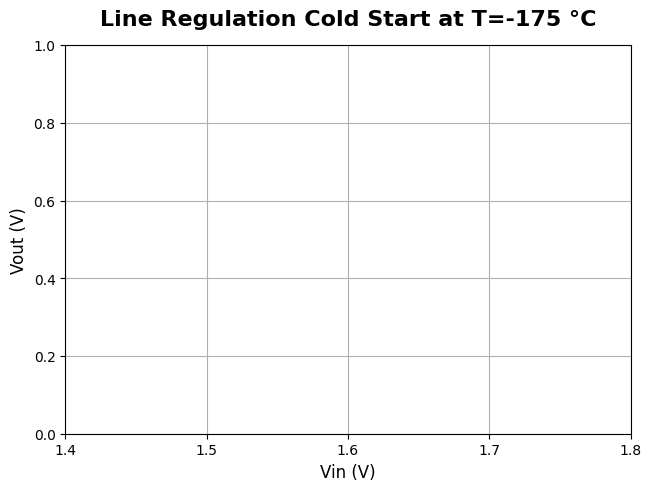

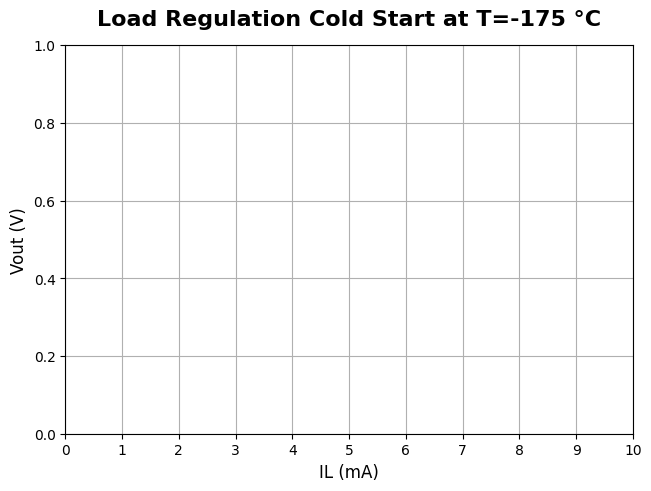

In [62]:
# PRACTICE Run, chamber stays at room temperature
Run_Experiment(False)
# If you run this while not connected to any equipment, will still generate test plots, as long as all plot initializations
# occur before any equipment interfacing. Can preview title, labels, ticks, etc. Not the lines or legends.

In [ ]:
#
#
# Buffer so we don't misclick
#
#

In [44]:
# ACTUAL Run, chamber sweeps temperature
Run_Experiment(True)

C:\Users\csylves1\AppData\Local\Temp\ipykernel_15780\2263571188.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, plot = plt.subplots(layout='constrained')


+20.000
00:30:00
YNNNYYYNYNNNNNNNNN0
YNNNYYYNYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNN